<a href="https://colab.research.google.com/github/AndreassOlsson/drone-anomalydetection/blob/main/UMCD_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import bisect
import tarfile
import pickle
from glob import glob

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn # nn.BCELoss
import torch.optim as optim
import torch.nn.functional as F 
import torch.utils.data as data # data.DataLoader, data.Dataset
import torchvision.transforms as transforms # ToTensor
from tqdm import tqdm



np.random.seed(42)
torch.manual_seed(42)

%matplotlib inline
plt.style.use('ggplot')

In [ ]:
tarfile.open(r'/content/drive/MyDrive/Andreas Olsson/Public-Safety/data/UMCD/umcd-extracted.tgz', 'r:gz').extractall()

In [ ]:
class UMCD_video_dset(data.Dataset):
  def __init__(self, video_folder, tfms, resize_height=256, resize_width=256, n_input_frames=6, n_pred_frames=1):
    self.video_paths = glob(os.path.join(video_folder, '*.mp4'))
    self.n_input_frames = n_input_frames
    self.n_pred_frames = n_pred_frames
    self.n = self.n_input_frames + self.n_pred_frames
    self.tfms = tfms

    self.setup()


  def setup(self):
    frame_intervals = []
    for video_path in self.video_paths:
      cap = cv2.VideoCapture(video_path)
      fs = cap.get(cv2.CAP_PROP_FRAME_COUNT)
      fs = int((fs // self.n) * self.n)

      if len(frame_intervals) == 0: frame_intervals = [fs // self.n]
      else: frame_intervals.append(frame_intervals[-1] + fs // self.n)
      cap.release()

    self.frame_intervals = frame_intervals
    

  def __getitem__(self, batch_idx):
    frame_idxs = list(map(lambda x: x + batch_idx * self.n, range(self.n)))
    video_idx = bisect.bisect_right(self.frame_intervals, batch_idx)
    
    all_frames = np.empty((self.n, resize_height, resize_width, 3))
    cap = cv2.VideoCapture(self.video_paths[video_idx])

    for i, frame_idx in enumerate(frame_idxs):
      tup = cap.read(frame_idx)
      assert tup[0] is not None, 'Videoframe not sucessfully extracted'
      all_frames[i] = self.tfms(tup[1])
    cap.release()

    input_frames, target_frames = all_frames[:self.n_input_frames], all_frames[self.n_input_frames:]
    return (input_frames, target_frames)

  def __len__(self): 
    return self.frame_intervals[-1]


  def show(self, idx=None):
    idx = idx if idx else random.randint(0, len(self.video_batches))
    n_imgs = (self.n_input_frames + self.n_pred_frames)

    f, axs = plt.subplots(1, n_imgs, figsize=(n_imgs*3, 3))
    input_frames = self.video_batches[idx][0]
    target_frames = self.video_batches[idx][1]

    for i, img in enumerate(input_frames): 
      axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Input frame {i+1}')
      axs[i].axis('off')

    for n, img in enumerate(target_frames): 
      i = n + self.n_input_frames
      axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Target frame {n+1}')
      axs[i].axis('off')

    plt.tight_layout()
    plt.show()

resize_height, resize_width = 256, 256
tfms = transforms.Compose([
    transforms.Resize((resize_height, resize_width)),
    transforms.ToTensor(),
    ])

normal_dset = UMCD_video_dset('/content/umcd-extracted/Normal', tfms=tfms, resize_height=resize_height, resize_width=resize_width)

NameError: ignored

In [ ]:
%%timeit

cap = cv2.VideoCapture('/content/umcd-extracted/Normal/Dirt-18-nt.mp4')
for _ in range(7):
  cap.read(0)

179 ms ± 71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
normal_dl = data.DataLoader(normal_dset, batch_size = 128, shuffle = True)
torch.save(train_dl, 'umcd_train.pth')

In [ ]:
def display_frames(video_path=None, cv2_videocapture=None, n_frames=10, starting_frame=0, interval=30, n_cols=5):
  """
  If cv2_videocapture is provided, it overwrites the video_path
  """
  cap = cv2.VideoCapture(video_path) if not cv2_videocapture else cv2_videocapture
  n_frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  frames = [starting_frame + interval * i for i in range(n_frames) if starting_frame + interval * i <= n_frames_total]
  n_frames = len(frames)

  n_rows = bisect.bisect_right([i for i in range(n_frames) if i % n_cols == 0], n_frames)
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
  axs = axs.flatten()

  for i, frame in enumerate(frames):
      cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
      res, img = cap.read()
      if res:
          axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
          axs[i].set_title(f'Frame: {frame}')
          axs[i].axis('off')

  plt.tight_layout()
  plt.show()
  cap.release()

def inspect_video(video_path=None, cv2_videocapture=None, df=True, n_frames=10, starting_frame=0, interval=30, n_cols=5):
  cap = cv2.VideoCapture(video_path) if not cv2_videocapture else cv2_videocapture
  fs = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  fps = cap.get(cv2.CAP_PROP_FPS)
  height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
  width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
  print(f'Videospecs:\nFrames {fs}, FPS {fps}, Height {height}, Width {width}')
  print(f'Shape of np array: {cap.read(0)[1].shape}\n')
  if df: display_frames(cv2_videocapture=cap, n_frames=n_frames, starting_frame=starting_frame, interval=interval, n_cols=n_cols)
  else: cap.release()

Videospecs:
Frames 400.0, FPS 49.967, Height 1080.0, Width 1920.0
Shape of np array: (1080, 1920, 3)



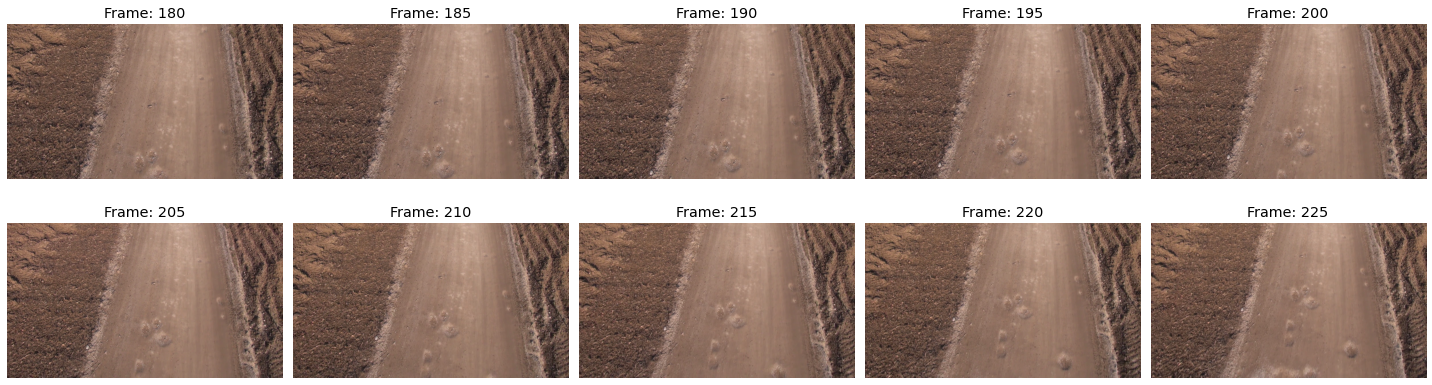

Videospecs:
Frames 799.0, FPS 49.924, Height 1080.0, Width 1920.0
Shape of np array: (1080, 1920, 3)



In [ ]:
inspect_video('/content/umcd-extracted/Normal/Dirt-18-nt.mp4', df=True, starting_frame=180, interval=5)
inspect_video('/content/umcd-extracted/Normal/Dirt-15-nt.mp4', df=False, starting_frame=180, interval=5)

#### hide

In [ ]:
class UMCD_video_dset(data.Dataset):
  def __init__(self, video_folder, tfms, n_input_frames=6, n_pred_frames=1):
    self.video_paths = glob(os.path.join(video_folder, '*.mp4'))
    self.video_paths = ['/content/umcd-extracted/Normal/Dirt-18-nt.mp4']
    self.n_input_frames = n_input_frames
    self.n_pred_frames = n_pred_frames
    self.tfms = tfms

    self.setup()


  def setup(self):
    """
    Procedures are taken to prevent RAM crashes
    """
    all_frames = []
    for i, video_path in enumerate(self.video_paths):
      print(f'Working on video {video_path}...')
      cap = cv2.VideoCapture(video_path)
      n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
      frame_idxs = tuple(range(int(n_frames // (self.n_input_frames + self.n_pred_frames)) * (self.n_input_frames + self.n_pred_frames)))

      def get_frame_from_videocapture(idx): 
        tup = cap.read(idx)
        if not tup[0]: raise Exception('Jalla JIEEEEEP O_o')
        return tup[1]
      
      print('Attempting to get frame from videocapture for every frame')
      video_frames = list(map(get_frame_from_videocapture, frame_idxs))
      print('Succeeded')

      if len(all_frames) == 0: all_frames = video_frames
      else: all_frames += video_frames
      print(f'Finished with video {i+1}/{len(self.video_paths)}\n')
      cap.release()

    self.video_batches = [(all_frames[i*(self.n_input_frames+self.n_pred_frames):(i+1)*(self.n_input_frames+self.n_pred_frames)][:self.n_input_frames], 
                           all_frames[i*(self.n_input_frames+self.n_pred_frames):(i+1)*(self.n_input_frames+self.n_pred_frames)][self.n_input_frames:]) 
                            for i in range(int(len(all_frames) // (self.n_input_frames + self.n_pred_frames)))]


  def __getitem__(self, idx):
    tup = self.video_batches[idx]
    input_frames = torch.stack(tuple([self.tfms(frame) for frame in tup[0]]))
    target_frames = torch.stack(tuple([self.tfms(frame) for frame in tup[1]]))
    return (input_frames, target_frames)

  def __len__(self):  
    return len(self.video_batches)

  def show(self, idx=None):
    idx = idx if idx else random.randint(0, len(self.video_batches))
    n_imgs = (self.n_input_frames + self.n_pred_frames)

    f, axs = plt.subplots(1, n_imgs, figsize=(n_imgs*3, 3))
    input_frames = self.video_batches[idx][0]
    target_frames = self.video_batches[idx][1]

    for i, img in enumerate(input_frames): 
      axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Input frame {i+1}')
      axs[i].axis('off')

    for n, img in enumerate(target_frames): 
      i = n + self.n_input_frames
      axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Target frame {n+1}')
      axs[i].axis('off')

    plt.tight_layout()
    plt.show()

tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ])

normal_dset = UMCD_video_dset('/content/umcd-extracted/Normal', tfms=tfms)

Working on video /content/umcd-extracted/Normal/Dirt-18-nt.mp4...
Attempting to get frame from videocapture for every frame
Succeeded
Finished with video 1/1



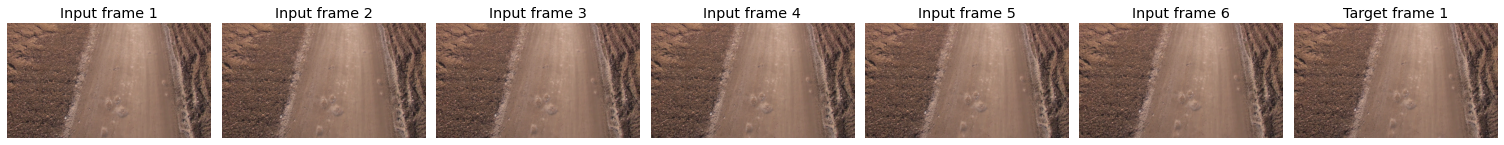

In [ ]:
normal_dset.show(29)